In [1]:
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Polygon, Rectangle
from mpl_toolkits.mplot3d import Axes3D
from google.cloud import firestore as fs
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
import keras
from keras.models import Sequential
from keras.layers import Dense
from bayes_opt import BayesianOptimization
from matplotlib import rc

Using TensorFlow backend.


In [2]:
from lib.control import *
from lib.parse import *
from lib.simulation import *
from lib.plot import *

In [3]:
%load_ext google.cloud.bigquery
%matplotlib inline
%load_ext autoreload
%autoreload 2

WIND SIMULATION:

 - 09-06: dir: 0, spd: 0
 - 09-11: dir: 90, spd: 10
 - 09-16: dir: 90, spd: 10
 - 09-27: dir: 180, spd: 5
 

In [193]:
%%bigquery flight_data
SELECT * 
FROM `dronemissioncont-1535032526252.logs.5bc58f50edbdd74bc230c409`
WHERE FlightTime > '2019-11-02 10:11:20'
ORDER BY Timestamp

In [191]:
%%bigquery ft
SELECT DISTINCT FlightTime
FROM `dronemissioncont-1535032526252.logs.5bc58f50edbdd74bc230c409`
ORDER BY FlightTime

In [192]:
ft[-5:]

,FlightTime
56,2019-11-02 10:33:32.129680+00:00
57,2019-11-02 10:37:16.219476+00:00
58,2019-11-02 10:40:53.810973+00:00
59,2019-11-02 10:45:00.126669+00:00
60,2019-11-06 10:32:11.653521+00:00


In [323]:
flight_data.Timestamp.max()

Timestamp('2019-10-25 14:59:50.352422+0000', tz='UTC')

In [176]:
%%bigquery flight_data_real
SELECT * 
FROM `dronemissioncont-1535032526252.logs.5cc20e22adeedd0001a66a34`
ORDER BY Timestamp

In [177]:
flight_data_real['Attitude'] = [{'Pitch': 0.0, 'Yaw': 0.0, 'Roll': 0.0}] * len(flight_data_real)

In [194]:
parsed = parse_flight_data(flight_data, ['Position', 'Speed', 'Attitude', 'Velocity', 'Wind'])

In [178]:
parsed_real = parse_flight_data(flight_data_real, ['Position', 'Speed', 'Attitude', 'Wind'])

In [195]:
parsed = apply_concat(parsed, lambda row: get_wind(row))

In [179]:
parsed_real = apply_concat(parsed_real, lambda row: get_wind(row))

In [7]:
client = fs.Client(project='dronemissioncontrol-prod')

In [8]:
missions = get_missions(client, '5bc58f50edbdd74bc230c409')
missions_real = get_missions(client, '5cc20e22adeedd0001a66a34')

In [196]:
wp_df = apply_concat(parsed, lambda row: parse_wp_data(missions, parsed, row)).dropna().reset_index()

In [180]:
wp_df_real = apply_concat(parsed_real, lambda row: parse_wp_data(missions_real, parsed_real, row)).dropna().reset_index()


In [181]:
wp_df_real.FlightTime.unique()

<DatetimeArray>
['2019-09-18 05:14:56.024180+00:00', '2019-09-18 05:18:04.351055+00:00',
 '2019-09-18 07:55:42.633888+00:00', '2019-09-18 12:21:24.555990+00:00']
Length: 4, dtype: datetime64[ns, UTC]

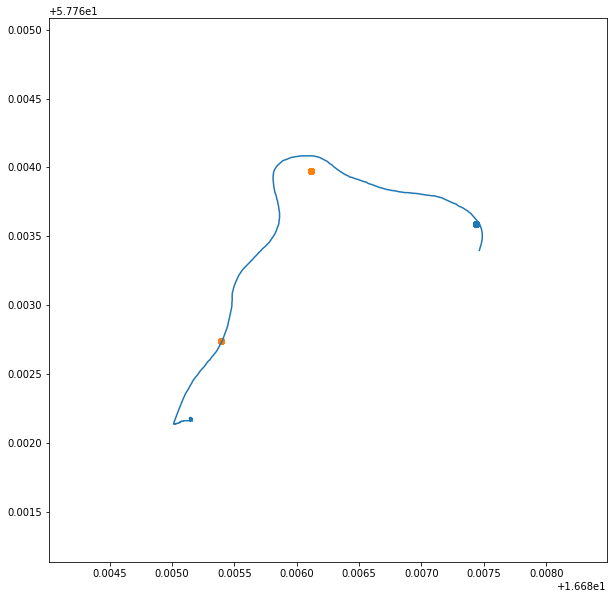

In [182]:
plot_trajectory(wp_df_real[(wp_df_real.FlightTime == wp_df_real.FlightTime.unique()[0])&(wp_df_real.Lat != 0)])

In [2894]:
wp_df_real[wp_df_real.FlightTime == wp_df_real.FlightTime.unique()[2]].Lat.describe()

count    11022.000000
mean        57.755451
std          0.550177
min          0.000000
25%         57.760742
50%         57.760750
75%         57.760760
max         57.760784
Name: Lat, dtype: float64

In [2880]:
parsed_real.FlightTime.unique()

<DatetimeArray>
['2019-09-05 07:22:34.986754+00:00', '2019-09-18 05:08:35.238672+00:00',
 '2019-09-18 05:13:51.709672+00:00', '2019-09-18 05:14:56.024180+00:00',
 '2019-09-18 05:17:00.603346+00:00', '2019-09-18 05:18:04.351055+00:00',
 '2019-09-18 07:51:33.032514+00:00', '2019-09-18 07:53:10.017531+00:00',
 '2019-09-18 07:54:35.205753+00:00', '2019-09-18 07:55:42.633888+00:00',
 '2019-09-18 12:21:24.555990+00:00']
Length: 11, dtype: datetime64[ns, UTC]

In [11]:
with open('parameters/2019_08_20_parrot.params') as file:
    params = file.read().split('\n')[8:-1]
    p_dict = {}
    for line in params:
        split = line.split('\t')
        p_dict[split[2]] = split[3]
with open('parameters/plane.parm') as file:
    params = file.read().split('\n')[:-1]
    p_array = []
    for line in params:
        split = line.split(' ')
        if split[0] in p_dict:
            if not split[0].startswith('INS_'):
                split[-1] = p_dict[split[0]]
            p_array += [' '.join(split)]
with open('parameters/overwrite.parm', 'w') as file:
    for line in p_array:
        file.write(line + '\n')

In [663]:
wp_df['L1_acc'] = wp_df.apply(lambda r: L1_controller(r.Lat, r.Lng, r.Lat_c, r.Lng_c, r.Lat_n, r.Lng_n, r.Airspeed, r.Yaw, r.Wind_spd, r.Wind_dir-180)[0], axis=1)
#wp_df_real['L1_acc'] = wp_df_real.apply(lambda r: L1_controller(r.Lat, r.Lng, r.Lat_c, r.Lng_c, r.Lat_n, r.Lng_n, r.Airspeed, r.Yaw, 0, 0)[0], axis=1)


KeyboardInterrupt: 

In [211]:
wp_df['RelAlt'] = wp_df.Alt - wp_df.Home_alt

In [ ]:
wp_df = wp_df.iloc[::3].reset_index()

In [11]:
wp_df['YawRate_deg'] = np.degrees(wp_df.YawRate)
wp_df['RollRate_deg'] = np.degrees(wp_df.RollRate)

In [336]:
wp_df['Roll_cmd'] = np.arctan(wp_df.L1_acc/9.81)

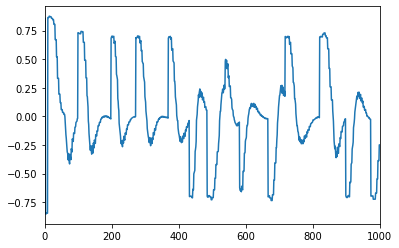

In [4354]:
wp_df.Roll_cmd.loc[:1000].plot()

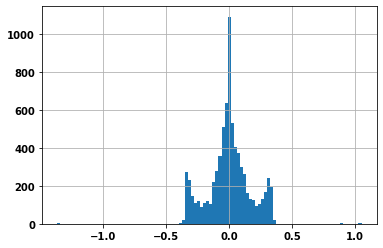

In [351]:
wp_df.YawRate[np.abs(wp_df.YawRate)>0.005].hist(bins=100)

In [359]:
np.degrees(wp_df.YawRate[np.abs(wp_df.YawRate)>0.1]).describe()

count    3414.000000
mean        0.140324
std        14.405292
min       -78.368778
25%       -13.790398
50%         5.994083
75%        13.501193
max        60.362851
Name: YawRate, dtype: float64

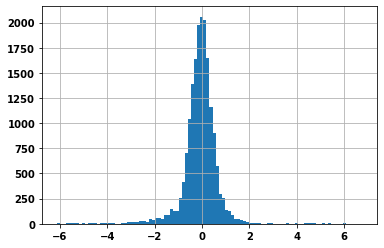

In [347]:
wp_df.Climb.hist(bins=100)

In [109]:
def get_strided(series, win_size=3):
    as_strided = np.lib.stride_tricks.as_strided
    return as_strided(series, (len(series) - (win_size - 1), win_size), (series.values.strides * 2))

In [4422]:
def get_features(df, input_cols, output_cols, na):
    win_size = max(na+1, nb+1)
    in_strided = get_strided(df[input_cols[0]], win_size)
    in_strided = in_strided[:, -(na+1):-1]
    for col in input_cols[1:]:
        in_ = get_strided(df[col], win_size)
        in_ = in_[:, -(na+1):-1]
        in_strided = np.concatenate((in_strided, in_), axis=1)
    in_strided = np.concatenate((in_strided, -1*in_strided), axis=0)
    
    out_strided = get_strided(df[output_cols[0]], win_size)
    out_curr = out_strided[:, -1].reshape(-1, 1)
    for col in output_cols[1:]:
        out_ = get_strided(df[col], win_size)[:, -1].reshape(-1, 1)
        out_curr = np.concatenate((out_curr, out_), axis=1)
    
    out_curr = np.concatenate((out_curr, -1*out_curr), axis=0)
    
    return in_strided, out_curr

In [362]:
ft = wp_df.FlightTime.unique()

In [363]:
ft

<DatetimeArray>
['2019-09-06 09:48:59.309264+00:00', '2019-09-06 14:43:22.507586+00:00',
 '2019-09-11 08:34:10.688040+00:00', '2019-09-16 11:02:35.436915+00:00',
 '2019-09-16 11:07:53.785596+00:00', '2019-09-16 11:32:13.078646+00:00',
 '2019-09-16 11:35:13.925702+00:00']
Length: 7, dtype: datetime64[ns, UTC]

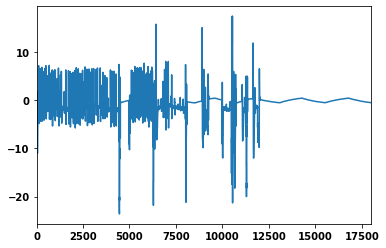

In [360]:
wp_df.Pitch.plot()

In [364]:
wp_df_all = wp_df[(wp_df.FlightTime < ft[3])]#|(wp_df.FlightTime==ft[-1])]

In [365]:
wp_df_train = wp_df[(wp_df.FlightTime == ft[1])]
wp_df_test = wp_df[wp_df.FlightTime == ft[0]]
wp_df_wind = wp_df[wp_df.FlightTime == ft[2]]
wp_df_train_wind = wp_df[wp_df.FlightTime == ft[-1]]

In [4594]:
np.max([wp_df_all.YawRate.max(), np.abs(wp_df_all.YawRate.min())])

0.38411117

In [4595]:
wp_df_test.Roll.describe()

count    4962.000000
mean       -0.408620
std        18.198603
min       -46.405228
25%        -5.607622
50%        -0.121543
75%         5.479536
max        53.383130
Name: Roll, dtype: float64

In [4596]:
wp_df_wind.Roll.describe()

count    2462.000000
mean        0.427069
std        10.819297
min       -51.555748
25%        -0.467038
50%        -0.270542
75%         0.544654
max        55.064014
Name: Roll, dtype: float64

In [4597]:
na = 5

In [4598]:
X, y = get_features(wp_df_train, ['L1_acc','Roll'], ['YawRate', 'RollRate'], na)

In [4599]:
X_eval, y_eval = get_features(wp_df_wind, ['L1_acc','Roll'], ['YawRate', 'RollRate'], na)

In [4600]:
X_all, y_all = get_features(wp_df_all, ['L1_acc','Roll'], ['YawRate', 'RollRate'], na)

In [4601]:
ss = StandardScaler().fit(X)
X_train_tf = ss.transform(X)
X_eval_tf = ss.transform(X_eval)

In [4602]:
mm = MaxAbsScaler().fit(y)
y_train_tf = mm.transform(y)
y_eval_tf = mm.transform(y_eval)

In [4603]:
model = Sequential()
model.add(Dense(10, activation='relu', input_shape=(X.shape[1],)))
model.add(Dense(10, activation='relu'))
#model.add(Dense(10, activation='relu'))
model.add(Dense(y.shape[1], activation='tanh'))
model.compile(optimizer='rmsprop', loss='mse')
history = model.fit(X_train_tf, y_train_tf, epochs=50, validation_split=0.25)

Train on 2197 samples, validate on 733 samples
Epoch 1/50
2197/2197 [==============================] - 3s 2ms/step - loss: 0.2140 - val_loss: 0.1200
Epoch 2/50
2197/2197 [==============================] - 0s 105us/step - loss: 0.1042 - val_loss: 0.0788
Epoch 3/50
2197/2197 [==============================] - 0s 95us/step - loss: 0.0643 - val_loss: 0.0533
Epoch 4/50
2197/2197 [==============================] - 0s 92us/step - loss: 0.0387 - val_loss: 0.0336
Epoch 5/50
2197/2197 [==============================] - 0s 93us/step - loss: 0.0222 - val_loss: 0.0265
Epoch 6/50
2197/2197 [==============================] - 0s 90us/step - loss: 0.0177 - val_loss: 0.0241
Epoch 7/50
2197/2197 [==============================] - 0s 89us/step - loss: 0.0159 - val_loss: 0.0221
Epoch 8/50
2197/2197 [==============================] - 0s 110us/step - loss: 0.0148 - val_loss: 0.0215
Epoch 9/50
2197/2197 [==============================] - 0s 91us/step - loss: 0.0140 - val_loss: 0.0204
Epoch 10/50
2197/2197 [==

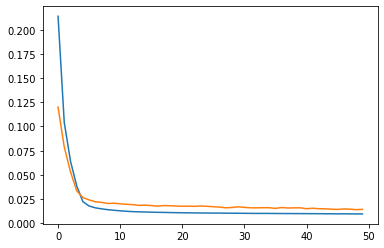

In [4604]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [4605]:
model.evaluate(X_eval_tf, y_eval_tf)

4914/4914 [==============================] - 0s 48us/step


0.006935788003629028

In [4606]:
ss_all = StandardScaler().fit(X_all)
mm_all = MaxAbsScaler().fit(y_all)

In [4607]:
y_pred = model.predict(ss_all.transform(X_eval))
y_pred = mm_all.inverse_transform(y_pred)

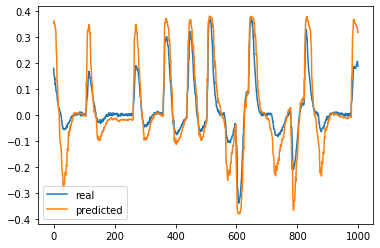

In [4608]:
plt.plot(y_eval[:1000, 0], label='real')
plt.plot(y_pred[:1000, 0], label='predicted')
#plt.plot(X_eval[:1000, na-1]/wp_df_wind.Airspeed.mean(), label='simple')
#plt.plot(np.radians(X_eval[:1000, -1]), label='roll')
plt.legend()

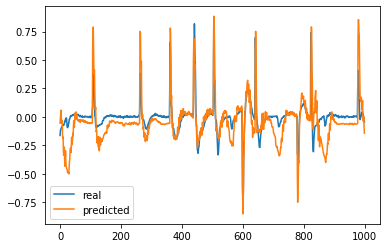

In [4609]:
plt.plot(y_eval[:1000, 1], label='real')
plt.plot(y_pred[:1000, 1], label='predicted')
#plt.plot(0.01*X_eval[8000:, -1], label='acc')
plt.legend()

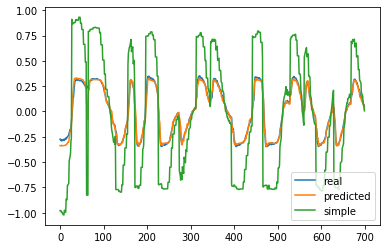

In [4610]:
y_pred_train = mm.inverse_transform(model.predict(X_train_tf))
plt.plot(y[:700, 0], label='real')
plt.plot(y_pred_train[:700, 0], label='predicted')
plt.plot(X[:700, na-1]/wp_df_train_wind.Airspeed.mean(), label='simple')
plt.legend()

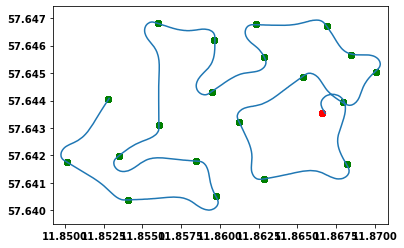

In [366]:
reached_times = wp_df_test.ReachedTime.unique()
#ft_real = wp_df_real.FlightTime.unique()
#wpx_df = wp_df_real[wp_df_real.FlightTime == ft_real[0]]
wpx_df = wp_df_test[(wp_df_test.Timestamp > reached_times[0]) & (wp_df_test.Timestamp < reached_times[20])].copy()
plt.plot(wpx_df.Lng, wpx_df.Lat)
plt.scatter(wpx_df.Lng_c, wpx_df.Lat_c, color='red')
plt.scatter(wpx_df.Lng_n, wpx_df.Lat_n, color='green')
ax = plt.gca()
bound = 0.0005
ax.set_xlim([wpx_df.Lng.min() - bound, wpx_df.Lng.max() + bound])
ax.set_ylim([wpx_df.Lat.min() - bound, wpx_df.Lat.max() + bound])
plt.show()

In [4623]:
wpx_df['dt'] = wpx_df.Timestamp.astype(int).rolling(2).apply(lambda x: (x[1] - x[0])/1e9, raw=True)

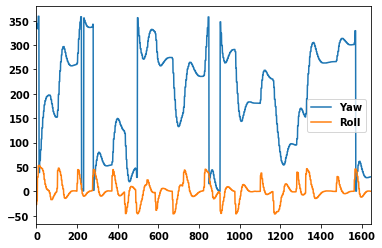

In [367]:
wpx_df.plot(y=['Yaw', 'Roll'])

In [4470]:
wpx_df.FlightTime.unique()

<DatetimeArray>
['2019-09-27 07:29:06.157354+00:00']
Length: 1, dtype: datetime64[ns, UTC]

In [2608]:
wps = missions_real['2019-08-20T08:18:51.444064788Z']['wps'][1:-1]

In [368]:
train_time = '2019-09-06T14:43:19.356193498Z'
test_time = '2019-09-06T09:48:56.585023287Z'
wind_time = '2019-09-11T08:34:08.039576221Z'
wind_time_2 = '2019-09-27T07:29:03.002040127Z'

In [369]:
wps = missions[test_time]['wps'][1:-1]
wps = wps[:21]

In [4624]:
# given mission simulation
ss_all = StandardScaler().fit(X_all)
mm_all = MaxAbsScaler().fit(y_all)
opts = {
        'V': wpx_df.Airspeed.mean(),
        'dt': wpx_df['dt'].mean()/2,
        'wps': wps,
        'wp_R': 10,
        'wind_spd': wpx_df.Wind_spd.mean(),
        'wind_dir': wpx_df.Wind_dir.mean() -180
    }
sim_df = Simulator(
    wpx_df.iloc[0],
    opts,
    model,
    ss_all,
    mm_all,
    na
).simulate_mission()
sim_df_simple = Simulator(
    wpx_df.iloc[0],
    opts,
    model,
    ss_all,
    mm_all,
    na
).simulate_mission(True)

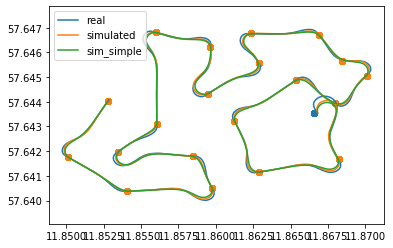

In [4628]:
fig, ax = plt.subplots()
ax.plot(wpx_df.Lng, wpx_df.Lat, label='real')
ax.plot(sim_df.Lng_p, sim_df.Lat_p, label='simulated')
ax.plot(sim_df_simple.Lng_p, sim_df_simple.Lat_p, label='sim_simple')
ax.scatter(wpx_df.Lng_c, wpx_df.Lat_c)
ax.scatter(wpx_df.Lng_n, wpx_df.Lat_n)
#ax.scatter(sim_df.iloc[2400].Lng_p, sim_df.iloc[2400].Lat_p, color='black')
#ax.scatter(wpx_df.iloc[600].Lng, wpx_df.iloc[600].Lat, color='purple')
bound = 0.001
ax.set_xlim([sim_df.Lng_p.min() - bound, sim_df.Lng_p.max() + bound])
ax.set_ylim([sim_df.Lat_p.min() - bound, sim_df.Lat_p.max() + bound])
plt.legend()
plt.show()

In [4259]:
def compare(fields, sim_idx=0, wpx_idx=0):
    sim_df.iloc[sim_idx:].plot(y=['{}_p'.format(f) for f in fields])
    wpx_df.loc[wpx_idx:].plot(y=fields)

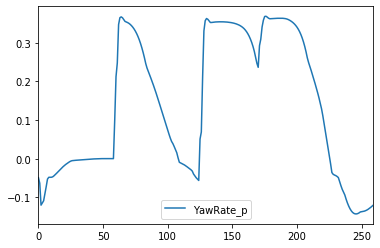

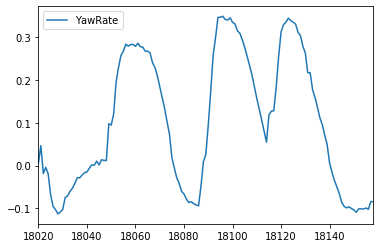

In [4542]:
compare(['YawRate'])

In [4582]:
wpx_df['YawRate_p'] = wpx_df.L1_acc/wpx_df.Airspeed

In [4583]:
wpx_df['Roll_rad'] = np.radians(wpx_df.Roll)

In [4584]:
wpx_df['Roll_cmd'] = np.degrees(np.arctan(wpx_df.L1_acc/9.82))

In [4585]:
wpx_df['Roll_error'] = np.radians(wpx_df.Roll - wpx_df.Roll_cmd)

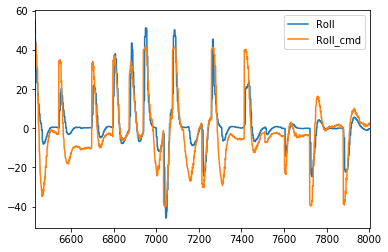

In [4586]:
wpx_df[['Roll','Roll_cmd']].plot()

In [4587]:
X_wpx, y_wpx = get_features(wpx_df, ['L1_acc','Roll'], ['YawRate', 'RollRate'], na)

In [4588]:
y_pred_wpx = mm_all.inverse_transform(model.predict(ss_all.transform(X_wpx)))

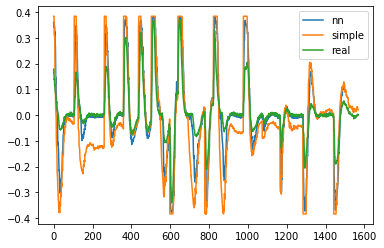

In [4591]:
plt.plot(y_pred_wpx[:1500,0], label='nn')
plt.plot(np.clip(wpx_df.YawRate_p.to_numpy()[na:],-0.38411117,0.38411117), label='simple')
plt.plot(wpx_df.YawRate.to_numpy()[na:], label='real')
#plt.plot(np.radians(wpx_df.Roll.to_numpy()[na:]), label='roll')
plt.legend()
plt.show()

In [4785]:
%time
res=simulate_primitive(85,65)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 7.15 µs


In [4]:
na=1

In [5]:
wind_spd = 5
airspeed = 14
wind_dir = 0
hdg = 180

In [6]:
wca = -np.arcsin(wind_spd/airspeed*np.sin(np.radians(wind_dir - hdg))) + np.radians(hdg)

In [438]:
np.degrees(wca)

180.0

In [439]:
v_sum = np.array([airspeed*np.cos(wca) + wind_spd, airspeed*np.sin(wca)])

In [440]:
v_sum

array([-9.00000000e+00,  1.71450552e-15])

In [441]:
v = np.dot(v_sum, np.array([np.cos(np.radians(hdg)), np.sin(np.radians(hdg))]))

In [444]:
t = 101.25/v

In [450]:
t*14

157.5

In [449]:
np.sqrt((t*14*np.sin(wca))**2 + (t*14*np.cos(wca))**2)

157.5

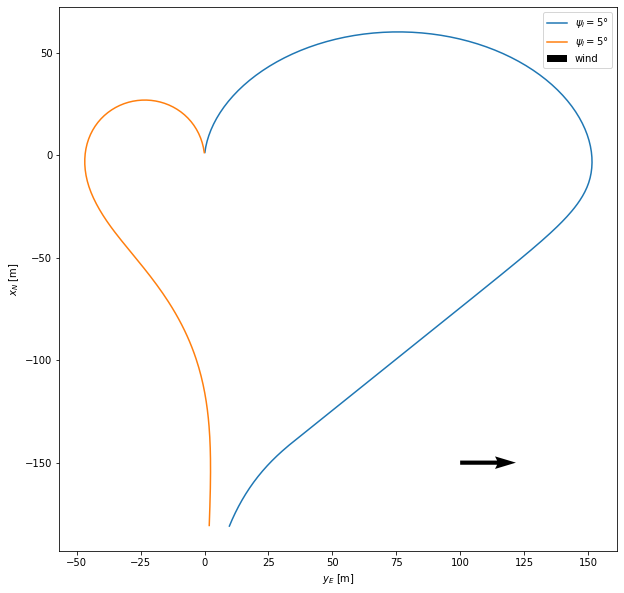

In [185]:
sim_1 = simulate_primitive(-180, 0, wind_dir=90, wind_spd=5, init_yaw=5)
sim_2 = simulate_primitive(-180, 0, wind_dir=90, wind_spd=5, init_yaw=-5)
_, ax = plt.subplots()
plot_primitive(sim_1, ax=ax, label='$\psi_i=5\degree$')
plot_primitive(sim_2, ax=ax, label='$\psi_i=5\degree$')
wind_rad = np.pi/2
ax.quiver(100,-150, np.sin(wind_rad), np.cos(wind_rad), scale=10, label='wind')
ax.set_xlabel('$y_E$ [m]')
ax.set_ylabel('$x_N$ [m]')
plt.legend()


In [4]:
def simulate_primitive(offset_x, offset_y, wind_dir=0, wind_spd=0, wind_err=0, init_yaw=0):
    V = 14
    init_yaw += np.degrees(-np.arcsin(wind_spd/V*np.sin(np.radians(wind_dir))))
    init = pd.Series({
            'Lat': 0.0,
            'Lng': 0.0,
            'Roll': 0,
            'Yaw': init_yaw,
            'L1_acc': 0.0,
            'Timestamp': pd.Timestamp(time.time())
        })
    ofs = offset([0, 0], offset_x, offset_y)
    opts = {
            'V': V,
            'dt': 0.1,#wpx_df['dt'].mean()/5,
            'wps': [{'lat': 0.0, 'lng': 0.0}, {'lat': ofs[0], 'lng': ofs[1]}],
            'wp_R': 0.1,
            'wind_dir': wind_dir,
            'wind_spd': (1 + wind_err)*wind_spd,
        }
    return Simulator(
        init,
        opts,
        None,#model,
        None,#ss_all,
        None,#mm_all,
        na
    ).simulate_mission(True)    

In [5]:
def plot_primitive(prim, origin=[0,0], ax=None, label='', color=None):
    if ax is None:
        _, ax = plt.subplots()
    local_path = np.zeros((prim.shape[0], 2))
    for i,row in prim.iterrows():
        local_path[i, :] = get_distance_NE([0, 0], [row.Lat_p, row.Lng_p])
    ax.plot(local_path[:, 1], local_path[:, 0], label=label, color=color)

In [6]:
def get_cost(traj, x, y, goal_hdg):
    #cost = acc_w*traj.L1_acc_p.sum()
    #cost = dist_w*norm(get_distance_NE([0,0], [traj.Lat_p.iloc[-1], traj.Lng_p.iloc[-1]]))
    V = 14
    cost = len(traj)*0.1*V + 10*end_xtrack(traj, x, y) + 10*np.abs(goal_hdg-end_bearing(traj))
    return cost

In [7]:
def end_bearing(traj):
    lat = traj.Lat_p.iloc[-2:].to_numpy()
    lng = traj.Lng_p.iloc[-2:].to_numpy()
    return bearing_to([lat[0],lng[0]], [lat[1], lng[1]])

In [8]:
def end_xtrack(traj, x, y):
    ll = offset([0, 0], x, y)
    a_pos = get_distance_NE([0, 0], [traj.Lat_p.iloc[-1], traj.Lng_p.iloc[-1]])
    ab = get_distance_NE([0, 0], ll)
    ab = ab/norm(ab)
    return norm(cross(a_pos, ab))

In [12]:
def is_valid(traj, x, y, goal_hdg):
    xtrack_error = end_xtrack(traj, x, y)
    valid_hdg = np.abs(end_bearing(traj)-goal_hdg) <= 10
    valid_pos = xtrack_error <= 2.5
    return valid_hdg and valid_pos

In [9]:
def plot_primitives(wind_spd, wind_error=0, goal_hdg=None, plot_wind_dir=None, ax=None):
    with open('route/primitives/{}.txt'.format(wind_spd)) as f:
        prims = f.read()
        if ax is None:
            _, ax = plt.subplots()
        lng_max = -np.inf
        lng_min = np.inf
        lat_max = -np.inf
        lat_min = np.inf
        label=True
        for line in prims.split('\n')[:-1]:
            values = line.split(' ')
            plot = False
            if (goal_hdg is None or float(values[-2]) == goal_hdg) and\
                (plot_wind_dir is None or float(values[-1]) == plot_wind_dir):
                wind_dir = float(values[-1])
                if float(values[0])> 0 or float(values[1]) > 0:
                    sim_df = simulate_primitive(float(values[0]), float(values[1]), wind_spd=wind_spd, wind_dir=wind_dir)
                    plot_primitive(sim_df, ax=ax, color='blue' if wind_error > 0 else None)
                    if wind_error != 0:
                        sim_df_low = simulate_primitive(float(values[0]), float(values[1]), wind_spd=wind_spd*(1-wind_error), wind_dir=wind_dir)
                        sim_df_high = simulate_primitive(float(values[0]), float(values[1]), wind_spd=wind_spd*(1+wind_error), wind_dir=wind_dir)
                        plot_primitive(sim_df_low, ax=ax, color='green')
                        plot_primitive(sim_df_high, ax=ax, color='red')
                    if label:
                        ax.scatter(float(values[1]), float(values[0]), color='red', label='$u$')
                        label=False
                    else:
                        ax.scatter(float(values[1]), float(values[0]), color='red')
        ax.axis('equal')

In [151]:
def plot_prims_from_file(path="", color="blue", axis=None):
    with open('route/primitives/visual{}.txt'.format(path)) as f:
        raw = f.read()
        #if ax is None:
        #    _, ax = plt.subplots()
        for line in raw.split('\n')[:-1]:
            prim = np.zeros((0, 2))
            vals = line.split(' ')[:-1]
            wp = vals[0]
            x, y = wp.split(',')
            axis.scatter(float(y), float(x), color='red')
            for val in vals[1:]:
                x, y = val.split(',')
                prim = np.append(prim, np.array([float(x), float(y)]).reshape(1, -1), axis=0)
            axis.plot(prim[:, 1], prim[:, 0], color=color)

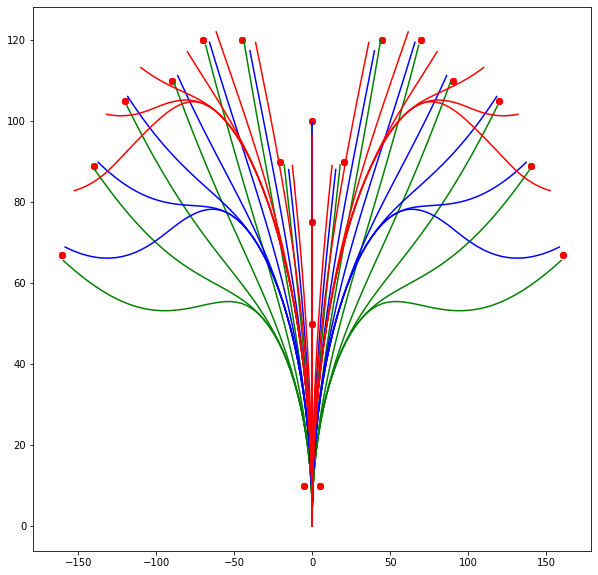

In [156]:
_, ax = plt.subplots()
plot_prims_from_file(path="_low", color="green", axis=ax)
plot_prims_from_file(axis=ax)
plot_prims_from_file(path="_high", color="red", axis=ax)


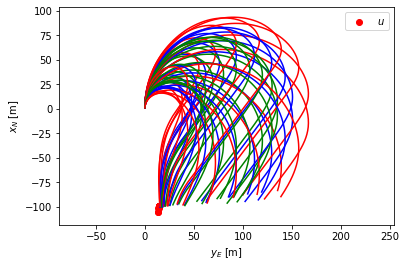

In [85]:
wind_dir=None
goal_hdg=180
#wind_rad = np.radians(wind_dir)
fig, ax = plt.subplots()
plot_primitives(5, wind_error=0.25, goal_hdg=goal_hdg, plot_wind_dir=wind_dir, ax=ax)
ax.set_xlabel('$y_E$ [m]')
ax.set_ylabel('$x_N$ [m]')
#ax.quiver(0,-100, np.sin(wind_rad), np.cos(wind_rad), scale=10, label='wind')
plt.legend()
plt.show()
#fig.savefig('mp_{}.png'.format(wind_dir))

In [117]:
def get_solution_wps():
    with open('route/sol.txt') as f:
        raw = json.load(f)
        wps = []
        for f in raw['features']:
            coords = f['geometry']['coordinates']
            wps += [{'lat': coords[1], 'lng': coords[0]}]
    return wps

In [118]:
def get_simulated(wp, path):
    origin = [wp['lat'], wp['lng']]
    with open(path) as f:
        raw = json.load(f)
        sim = np.zeros((len(raw['features']), 2))
        for i, f in enumerate(raw['features']):
            coords = f['geometry']['coordinates']
            sim[i, :] = get_distance_NE(origin, [coords[1], coords[0]])
    return sim

In [119]:
def get_visited(wp):
    origin = [wp['lat'], wp['lng']]
    with open('route/visited.txt') as f:
        raw = f.read()
        lines = raw.split('\n')
        visited = np.zeros((len(lines), 3))
        for i, l in enumerate(lines):
            values = l.split(' ')
            if len(values) == 3:
                ll = [float(values[0]), float(values[1]), float(values[2])]
                visited[i,:] = np.array(ll)
        
    return visited

In [120]:
def read_hlut():
    with open('route/hlut_viz.txt') as f:
        raw = f.read()
        lines = raw.split('\n')[:-1]
        n = len(lines)
        hlut = np.zeros((n, n))
        for i, line in enumerate(lines):
            values = line.split(' ')[:-1]
            hlut[i, :] = np.array([float(v) for v in values])
        return hlut

In [121]:
def read_obstacles():
    with open('route/obstacles.txt') as f:
        raw = f.read()
        lines = raw.split('\n')[:-1]
        obstacles = []
        for line in lines:
            values = line.split(' ')[:-1]
            obst = np.zeros((0, 2))
            for v in values:
                coords = v.split(',')
                p = np.array([float(coords[1]), float(coords[0])]).reshape(1, -1)
                obst = np.append(obst, p, axis=0)
            obstacles += [obst]
        return obstacles

In [122]:
def read_landing():
    with open('route/landing.txt') as f:
        raw = f.read()
        data = raw.split('\n')[0].split(' ')
        x, y, w, h, r = [float(d) for d in data]
        r_new = 90-r
        hdg = np.radians(r + 90)
        x_new, y_new = np.array([x, y]) + h*np.array([np.cos(hdg), np.sin(hdg)])
        return x_new, y_new, w, h, r_new

In [123]:
def read_landing_opt():
    with open('route/land_opt.txt') as f:
        raw = f.read()
        data = raw.split('\n')[:-1]
        opt = np.zeros((0,2))
        for line in data:
            values = line.split(' ')
            opt = np.append(opt, np.array([float(v) for v in values]).reshape(1, -1), axis=0)
        return opt

In [124]:
def read_grid():
    with open('route/grid_search.txt') as f:
        raw = f.read()
        lines = raw.split('\n')[:-1]
        nx = len(lines)
        ny = len(lines[0].split(' ')[:-1])
        grid = np.zeros((nx, ny))
        for i, line in enumerate(lines):
            values = line.split(' ')[:-1]
            grid[i, :] = np.array([float(v) if float(v) > 0 else np.nan for v in values ])
        return grid

In [125]:
def read_grid_opt():
    with open('route/log_opt.txt') as f:
        raw = f.read()
        data = raw.split('\n')[:-1]
        opt = np.zeros((0,2))
        for line in data:
            values = line.split(' ')
            opt = np.append(opt, np.array([float(v) for v in values]).reshape(1, -1), axis=0)
        return opt

3.8896406368357646

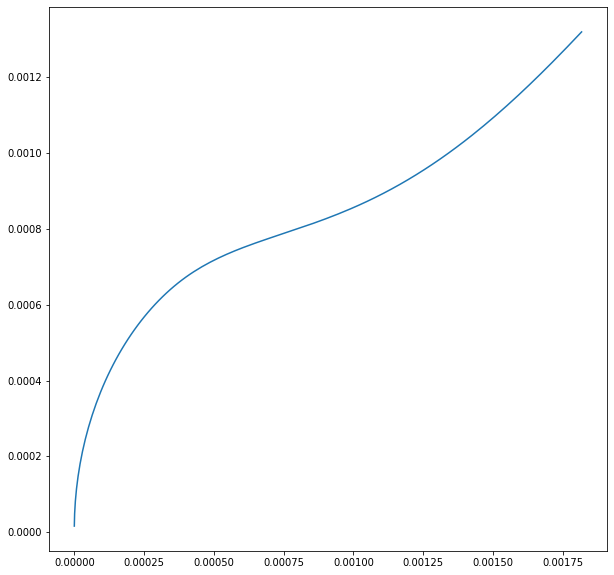

In [58]:
sim_df = simulate_primitive(150, 200, wind_spd=5, wind_dir=30)
plt.plot(sim_df.Lng_p, sim_df.Lat_p)
end_xtrack(sim_df, 150, 200)

In [388]:
y_ticks.shape

(201,)

In [424]:
grid

array([[    nan,     nan,     nan,     nan,     nan],
       [    nan,     nan,     nan,     nan,     nan],
       [    nan,     nan,     nan,     nan,     nan],
       [    nan,     nan,     nan,     nan,     nan],
       [    nan,     nan,     nan,     nan,     nan],
       [    nan,     nan, 556.626, 672.177, 794.525],
       [    nan,     nan,     nan,     nan,     nan],
       [    nan,     nan,     nan,     nan,     nan],
       [    nan,     nan,     nan,     nan,     nan],
       [    nan,     nan,     nan,     nan,     nan],
       [    nan,     nan,     nan,     nan,     nan]])

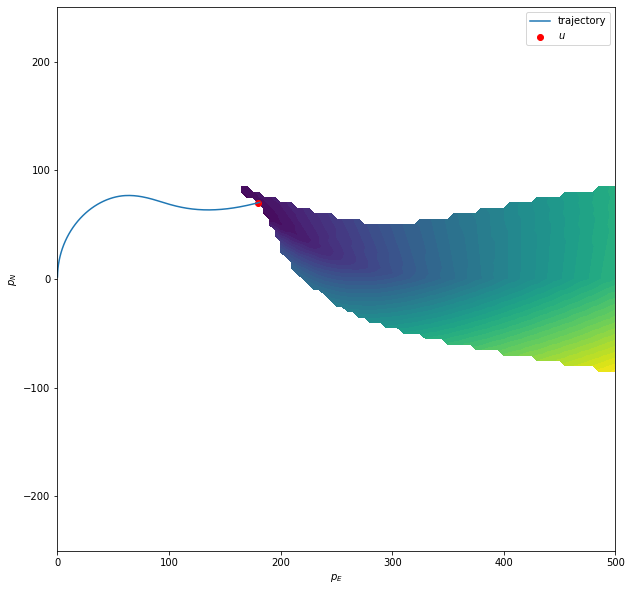

In [429]:
grid = read_grid()
step = 5
x_ticks = step*np.arange(1, grid.shape[1]+1, 1)
y_ticks = step*np.arange(-grid.shape[1], grid.shape[1]+1, 1)

X, Y = np.meshgrid(x_ticks, y_ticks)
fig, ax = plt.subplots()
surf = ax.contourf(X, Y, grid, 50)

sim_df = simulate_primitive(70, 180, wind_spd=5, wind_dir=0)
plot_primitive(sim_df, ax=ax, label='trajectory')
ax.scatter(180, 70, color='red', label='$u$')
#opt = read_grid_opt()
#ax.scatter(opt[:,1], opt[:,0])

ax.set_xlim([0, 500])
ax.set_ylim([-250, 250])
ax.set_xlabel('$p_E$')
ax.set_ylabel('$p_N$')
plt.legend()
plt.show()

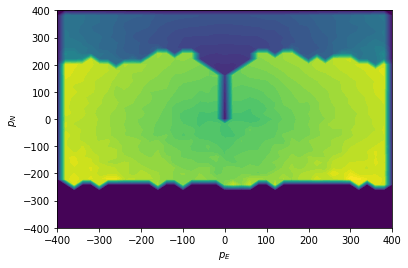

In [116]:
hlut = read_hlut()
X, Y = np.meshgrid(20*np.arange(-20, 21, 1), 20*np.arange(-20, 21, 1))
fig, ax = plt.subplots()
surf = ax.contourf(X, Y, hlut, 50)
ax.set_xlabel('$p_E$')
ax.set_ylabel('$p_N$')
fig.savefig('hlut.png')

In [29]:
wp_df.FlightTime.unique()[-4]

Timestamp('2019-11-02 10:33:32.129680+0000', tz='UTC')

Ordning: 90, 0, 180, 270

In [33]:
na=1
opts = {
        'V': 14,
        'dt': 0.1,
        'wps': get_solution_wps(),
        'wp_R': 1,
        'wind_spd': 5,
        'wind_dir': 0
    }
init = pd.Series({
        'Lat': wps[0]['lat'],
        'Lng': wps[0]['lng'],
        'Roll': 0,
        'Yaw': 0,
        'L1_acc': 0.0,
        'Timestamp': pd.Timestamp(time.time())
    })
sim_df = Simulator(
    init,
    opts,
    None,
    None,
    None,
    na
).simulate_mission(True)

In [356]:
land = wp_df[wp_df.FlightTime == wp_df.FlightTime.unique()[-1]].reset_index(drop=True).copy()

In [35]:
wp_df.to_csv('results.csv')

In [574]:
rc('text', usetex=False)

In [599]:
lo = read_landing_opt()

In [357]:
land = land[(land.Lat > 0)].copy().reset_index(drop=True)

In [204]:
local_path

array([[-6.41717444e+06, -7.06688865e+05],
       [-6.41717444e+06, -7.06688865e+05],
       [-6.41717444e+06, -7.06688865e+05],
       ...,
       [-4.97283544e+02,  6.54087814e+01],
       [-4.97283544e+02,  6.54087814e+01],
       [-4.97283544e+02,  6.54087814e+01]])

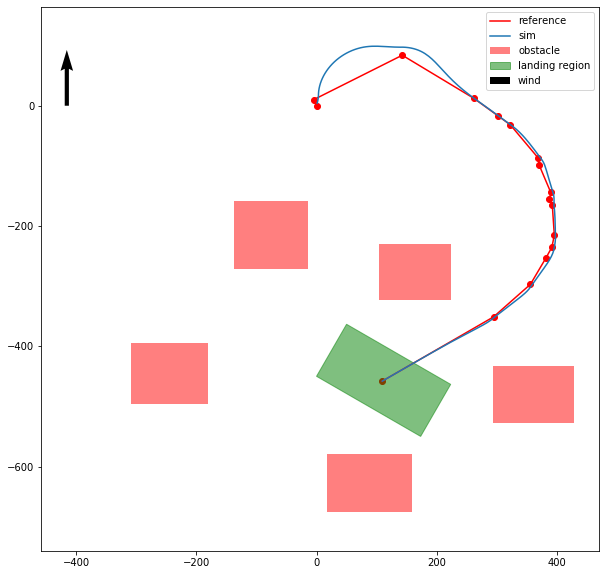

In [131]:
wps = get_solution_wps()
visited = get_visited(wps[0])
sim = get_simulated(wps[0], 'route/sim.txt')
sim_astar = get_simulated(wps[0], 'route/sim_astar.txt')
obst = read_obstacles()
plt.rcParams['figure.figsize'] = [10, 10]
origin = [wps[0]['lat'], wps[0]['lng']]
#local_path = np.zeros((land.shape[0], 2))
#for i,row in land.iterrows():
#    local_path[i, :] = get_distance_NE(origin, [row.Lat, row.Lng])
local_wps = np.zeros((len(wps), 2))
for i, wp in enumerate(wps):
    local_wps[i, :] = get_distance_NE(origin, [wp['lat'], wp['lng']])
fig, ax = plt.subplots()
for i, o in enumerate(obst):
    if i==0:
        ax.add_patch(Polygon(o, alpha=0.5, facecolor='red', label='obstacle'))
    else:
        ax.add_patch(Polygon(o, alpha=0.5, facecolor='red'))
x, y, w, h, r = read_landing()
ax.add_patch(Rectangle((y,x), w, h, r, alpha=0.5, color='green', label='landing region'))
#ax.quiver(visited[:, 1], visited[:, 0], np.sin(np.radians(visited[:, 2])), np.cos(np.radians(visited[:, 2])), color='green', alpha=0.5)
ax.scatter(local_wps[:, 1], local_wps[:, 0], color='red')
ax.plot(local_wps[:, 1], local_wps[:, 0], color='red', label='reference')
#ax.plot(local_path[:, 1], local_path[:, 0], label='trajectory')
ax.plot(sim[:, 1], sim[:, 0], label='sim')
#ax.scatter(sim_astar[:, 1], sim_astar[:, 0], label='sim-astar', color='orange')

#ax.scatter(lo[:,1], lo[:,0] , color='blue')
ax.axis('equal')
wind_dir = np.radians(0)
ax.quiver(1.2*ax.get_xlim()[0], 0*ax.get_ylim()[1], np.sin(wind_dir), np.cos(wind_dir), scale=10, label='wind')
plt.legend()
plt.show()
fig.savefig('{}.png'.format(np.degrees(wind_dir)))


In [158]:
np.sin(np.pi/4)

0.7071067811865475

In [159]:
1/np.sqrt(2)

0.7071067811865475

In [267]:
land = land[870:1300].copy()
land = apply_concat(land, land_dist)

In [344]:
pitch = land[land.RelAlt > 5].Pitch.mean()
speed = land[land.RelAlt > 5].Groundspeed.mean()
sink_real = land[land.RelAlt > 5].Climb.mean()

In [345]:
sink_real

-1.9795454847389558

In [343]:
pitch

-9.39490119317269

In [292]:
speed*np.arctan(np.radians(pitch))

-1.8882287952611803

In [303]:
total_dist = 209.842+50

In [310]:
sink_rate = 40*speed/total_dist

In [311]:
slope = (40 - 2*sink_rate)/total_dist

In [312]:
np.degrees(np.arctan(slope))

7.9793779919092405

In [319]:
flare_dist = speed*(2*sink_rate)/.25

In [327]:
flare_dist = np.min([flare_dist, total_dist/2])

In [328]:
flare_dist

129.921

In [329]:
total_dist + (500 - flare_dist)

629.921

In [350]:
real_slope = (40 + 500*slope - 2*sink_rate)*speed/(total_dist + (500 - flare_dist))

In [351]:
real_slope

1.9644311144049011

In [353]:
speed*3/.5

69.70820992771084

In [342]:
np.degrees(np.arctan(real_slope/speed))

9.597063763647673

In [338]:
40-2*sink_rate

36.423046316468685

In [348]:
land[(land.RelAlt < 4)&(land.RelAlt > 0)].Climb.describe()

count    104.000000
mean      -0.446957
std        0.719979
min       -1.672665
25%       -0.981816
50%       -0.457188
75%        0.239708
max        0.630776
Name: Climb, dtype: float64

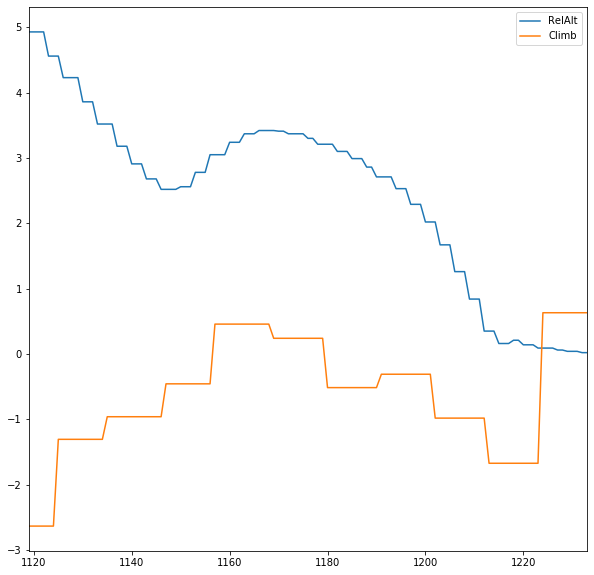

In [352]:
land[(land.RelAlt <= 5)&(land.RelAlt > 0)].plot(y=['RelAlt', 'Climb'])

In [290]:
11.4459*3/.5

68.6754

In [276]:
land.Dist[870]

208.19664278891753

In [275]:
land[(land.RelAlt < 4)&(land.RelAlt > 0)].Dist[1135]

3.9492609542077397

In [272]:
land[(land.RelAlt < 4)&(land.RelAlt > 0)].Dist[1230]

61.28318003993184

In [246]:
land['Dist_scaled'] = land.Dist*.25

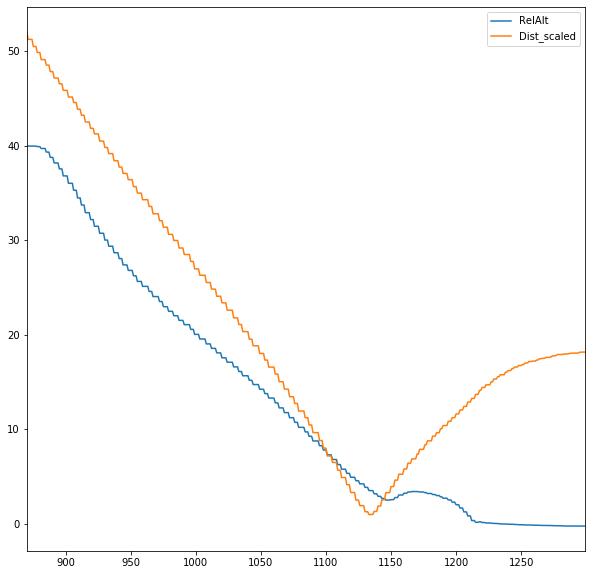

In [247]:
land.plot(y=['RelAlt', 'Dist_scaled'])

In [234]:
land.Dist.describe()

count    450.000000
mean      90.442228
std       60.308230
min        3.949261
25%       44.917523
50%       71.424233
75%      137.180341
max      225.022772
Name: Dist, dtype: float64

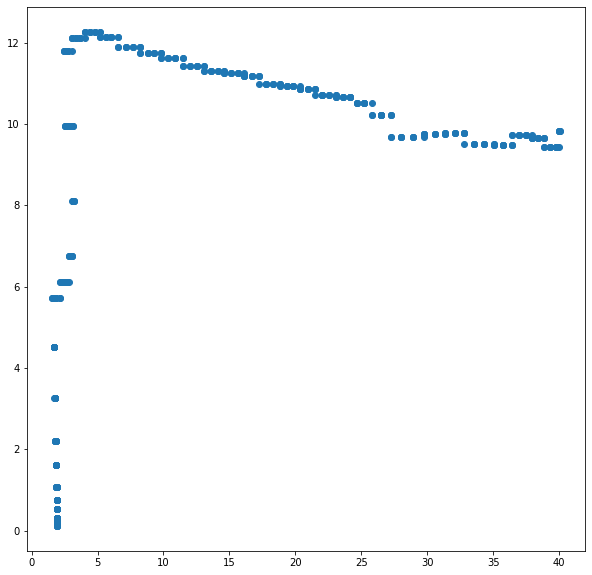

In [175]:
plt.scatter(land[950:1400].RelAlt, land[950:1400].Groundspeed)

In [247]:
end_bearing(sim_df)

87.90663135324692

In [248]:
end_xtrack(sim_df, opt[0], opt[1])

5.013044784981567

In [49]:
X

array([[  1,   2,   3, ..., 198, 199, 200],
       [  1,   2,   3, ..., 198, 199, 200],
       [  1,   2,   3, ..., 198, 199, 200],
       ...,
       [  1,   2,   3, ..., 198, 199, 200],
       [  1,   2,   3, ..., 198, 199, 200],
       [  1,   2,   3, ..., 198, 199, 200]])

In [157]:
%%time
wind_dir=30
wind_spd=5
x = np.arange(5, 202.5, 2.5)
y = np.arange(5, 202.5, 2.5)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
goal_hdg=45
for i, x_wp in enumerate(x):
    for j, y_wp in enumerate(y):
        res = simulate_primitive(x_wp, y_wp, wind_dir=wind_dir, wind_spd=wind_spd)
        if is_valid(res, x_wp, y_wp, goal_hdg):
            Z[i,j]=get_cost(res,x_wp,y_wp, goal_hdg)
        else:
            Z[i,j]=np.nan
print('done')

done
CPU times: user 2min 23s, sys: 1.1 s, total: 2min 25s
Wall time: 2min 26s


In [174]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}
rc('font', **font)
rc('text', usetex=True)

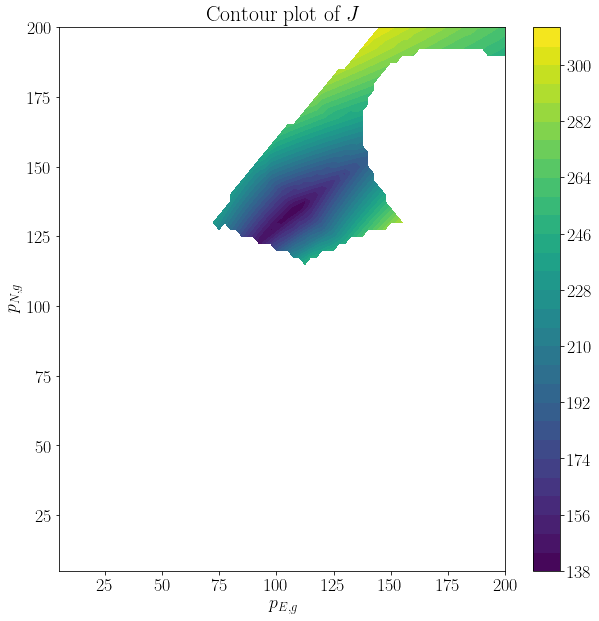

In [175]:
fig = plt.figure()
ax = fig.gca()
ax.set_xlabel('$p_{E,g}$')
ax.set_ylabel('$p_{N,g}$')
ax.set_title('Contour plot of $J$')
surf = plt.contourf(X, Y, Z, 30)
plt.colorbar(surf)
fig.savefig('J_opt_45.png', dpi=300)

In [5717]:
cost[int((opt[0]-5)/5),int((opt[1]-5)/5)] = 200000

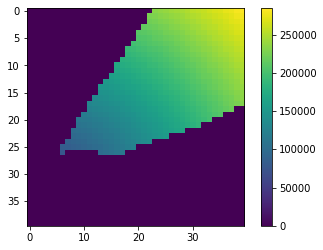

In [5728]:
plt.imshow(cost[::-1,:])
plt.colorbar()

In [5032]:
%%time
goal_hdg=45
x_max = -np.inf
x_min = np.inf
for x in np.arange(5, 205, 5):
    res = simulate_primitive(200,x, wind_spd=5, wind_dir=0)
    if is_valid(res, x, y, goal_hdg, 5):
        if x < x_min:
            x_min=x
        if x > x_max:
            x_max=x
print(x_min,x_max)

130 150
CPU times: user 520 ms, sys: 11.4 ms, total: 531 ms
Wall time: 526 ms


In [5042]:
140/200

0.7

In [2141]:
wpx_df.Roll.describe()

count    637.000000
mean       2.772691
std       15.644625
min      -45.718914
25%       -4.691104
50%        0.405877
75%        4.668044
max       51.155914
Name: Roll, dtype: float64

In [2142]:
sim_df.Roll_p.describe()

count    455.000000
mean       3.791203
std       16.427255
min      -44.431413
25%       -3.480576
50%       -0.047977
75%        9.041001
max       39.056557
Name: Roll_p, dtype: float64

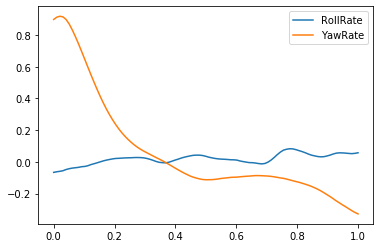

In [120]:
c_roll = []
c_yaw = []
for i in range(1, 100):
    c_roll += [wp_df.L1_acc[::3].shift(i).corr(wp_df.PitchRate[::3])]
    c_yaw += [wp_df.L1_acc[::3].shift(i).corr(wp_df.YawRate[::3])]
plt.plot(np.linspace(0, 1, 99), c_roll, label='RollRate')
plt.plot(np.linspace(0, 1, 99), c_yaw, label='YawRate')
plt.legend()

In [121]:
print(c_yaw.index(max(c_yaw)))
print(c_yaw[c_yaw.index(max(c_yaw))])

2
0.9177781112313698


In [183]:
land_df = wp_df[wp_df.Type_n == 'LAND'].copy()
land_df_real = wp_df_real[wp_df_real.Type_n == 'LAND'].copy()

In [184]:
land_df['RelAlt'] = (land_df.Alt - land_df.Home_alt).astype('float64')
land_df_real['RelAlt'] = (land_df_real.Alt - land_df_real.Home_alt).astype('float64')

In [185]:
land_df['Throttle_scaled'] = land_df.Throttle*100
land_df_real['Throttle_scaled'] = land_df_real.Throttle*100

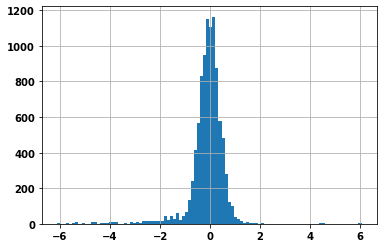

In [376]:
land_df.Climb.hist(bins=100)

In [187]:
land_real = land_df_real[(land_df_real.FlightTime == wp_df_real.FlightTime.unique()[0])]

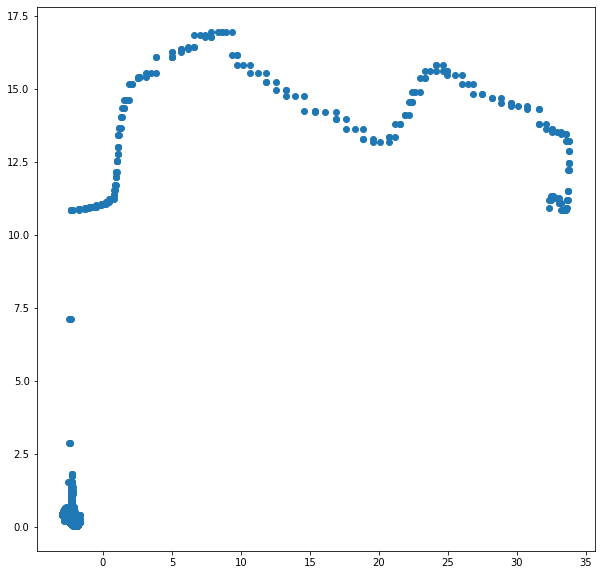

In [189]:
plt.scatter(land_real.RelAlt, land_real.Groundspeed)

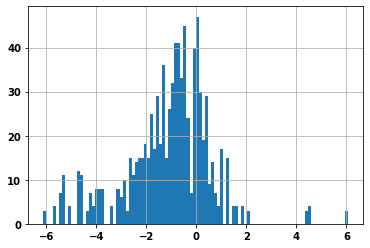

In [409]:
land_df[(land_df.Airspeed > 5)&(land_df.RelAlt >= 3)].reset_index(drop=True).Climb.hist(bins=100)

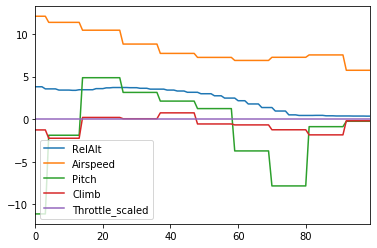

In [2951]:
land_df[(land_df.Groundspeed > 1)&(land_df.RelAlt <= 4)].reset_index()[:100].plot(y=['RelAlt', 'Airspeed', 'Pitch', 'Climb', 'Throttle_scaled'])


In [2804]:
land_df[land_df.Groundspeed > 1].Climb.describe()

count    3686.000000
mean       -0.855887
std         1.539167
min        -6.113663
25%        -1.509093
50%        -0.557227
75%         0.074076
max         6.052166
Name: Climb, dtype: float64

In [485]:
land_seq = land_df[land_df.Groundspeed > 1].reset_index(drop=True)

In [509]:
landing = land_seq.iloc[242:330].copy()

In [524]:
origin = [57.6432, 11.8630]
pos = np.zeros((0, 2))
alt = np.zeros((0))
for _, row in landing.iterrows():
    pos = np.append(pos, get_distance_NE(origin, [row.Lat, row.Lng]).reshape(1, -1), axis=0)
    alt = np.append(alt, row.RelAlt)

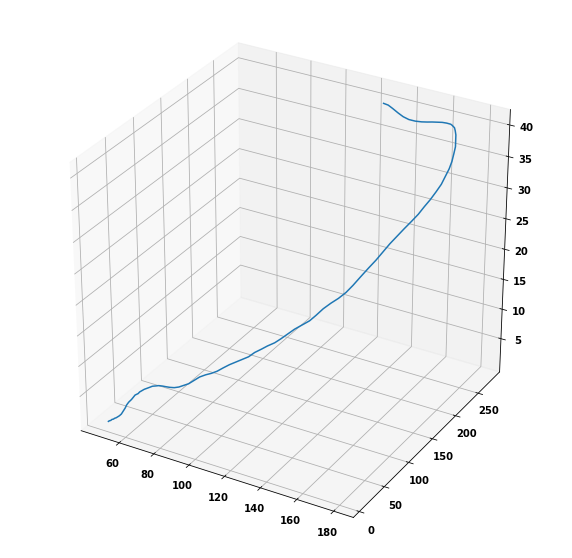

In [527]:
X, Y = np.meshgrid(pos[:, 0], pos[:, 1])
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot3D(pos[:, 0], pos[:, 1], alt)
plt.show()

In [224]:
def land_dist(row):
    dist = norm(get_distance_NE([row.Lat, row.Lng], [row.Lat_n, row.Lng_n]))
    return pd.Series({'Dist': dist})

In [483]:
land_df = apply_concat(land_df, land_dist)

In [2807]:
dh = land_seq.RelAlt.iloc[0]

In [2808]:
ds = np.linalg.norm(get_distance_NE([land_seq.iloc[0].Lat_c, land_seq.iloc[0].Lng_c],[land_seq.iloc[0].Lat_n, land_seq.iloc[0].Lng_n]))

In [2809]:
dh/ds

0.3213707090338731

In [2810]:
land_seq['dt'] = land_seq.Timestamp.astype(int).rolling(2).apply(lambda x: (x[1] - x[0])/1e9, raw=True)

In [2811]:
alt_p = [land_seq.iloc[0].RelAlt]
for _, r in land_seq.iterrows():
    dt = r['dt']
    if not np.isnan(dt):
        s_diff = r.Airspeed*dt
        h_diff = dh/ds*s_diff
        next_h = alt_p[-1] - h_diff
        if next_h < 0:
            next_h = 0
        alt_p +=[next_h]

In [2812]:
land_seq['RelAlt_p'] = alt_p

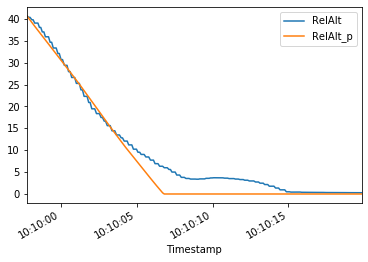

In [2813]:
land_seq.plot(x='Timestamp', y=['RelAlt', 'RelAlt_p'])

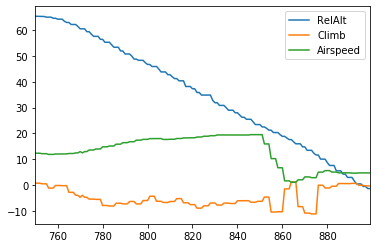

In [2945]:
land_df_real[land_df_real.Groundspeed > 1].reset_index()[750:900].plot(y=['RelAlt', 'Climb', 'Airspeed'])
